In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#Lectura de datos

#Datos producción mensual 
datos_est=pd.read_csv("https://raw.githubusercontent.com/mnaR99/narco_aguacate/main/data/processed/asc_michoacan.csv")
#datos de exportaciones
datos_exp=pd.read_csv("https://raw.githubusercontent.com/mnaR99/narco_aguacate/main/data/processed/exportaciones_mensuales.csv")
#datos de producción anual
datos_est_men=pd.read_csv("https://raw.githubusercontent.com/mnaR99/narco_aguacate/main/data/processed/dfMunicipios0319.csv")

#Cambiar los meses a números
mes_num = {"enero": 1, "febrero": 2, "marzo": 3, "abril": 4, "mayo": 5, 
           "junio": 6, "julio": 7, "agosto": 8, "septiembre": 9, "octubre": 10, 
           "noviembre": 11,"diciembre": 12}

datos_exp.mes = datos_exp.mes.map(mes_num)

0.5707102579260712


(<matplotlib.collections.PathCollection at 0x255d7108e88>, None)

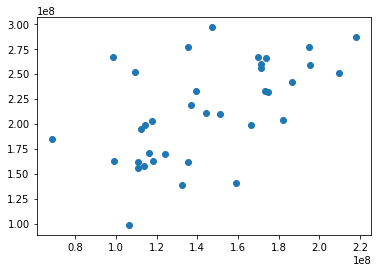

In [2]:
#Es para ver la relación que existen entre las prodiccones mensuales 
#y las exportaciones para ver que tan viable es estimar las producciones
#del 2015 al 2017 para tener unos datos mas completos para el modelo final


datos_exp=datos_exp[datos_exp["tipo"]=="Kg"]

#Estas son las exportaciones por mes 
expxmes=datos_exp.groupby(["anio","mes"],as_index=False)["unidades"].sum()
expxmes=expxmes[expxmes.anio.isin([2018,2019,2020])]

prod=datos_est.groupby(["anio","mes","entidad"],as_index=False).agg({"produccion": "sum"})
prod=prod[prod["entidad"]=="Michoacán"]

prod["prod_mes_kg"] = prod.groupby('anio')['produccion'].transform(lambda x: (x - x.shift(fill_value = 0)) * 1000)


plt.scatter(prod["prod_mes_kg"],expxmes["unidades"]),print(np.corrcoef(prod["prod_mes_kg"],expxmes["unidades"])[0,1])


In [3]:
#Ahora tenemos que completar todos los datos a un minimo de 6 años 

#Esto sirve para sumar los datos ya que existen cosechan que son temporales o de riego y recordando que aquí se tratan 
#datos anuales, aquí solo se llenan los datos faltantes más antiguos , para los datos del 2020 se hace más adelante
datos_anu_mun=datos_est_men[datos_est_men["Nomestado"]=="Michoacán"][["Anio","Nommunicipio","Volumenproduccion"]].groupby(["Anio","Nommunicipio"],as_index=False).agg({"Volumenproduccion":"sum"})

#Aquí lo que se intenta hacer es que todos los municipios tengan producción para despues llenarla con el ultimo registro 
#que tuvo el municipio

mun=datos_anu_mun["Nommunicipio"].unique()
mun_1=np.array([])
mun_fin=np.repeat(mun,5)
an=np.ones(0)
for i in [2015,2016,2017,2018,2019]:
     an=np.concatenate((np.ones(len(mun)).astype("int")*i,an.astype("int")))
     mun_1=np.concatenate((mun_1,mun))
datos_totales=pd.DataFrame({"Anio":an,"Nommunicipio":mun_1})
d=pd.merge(datos_totales,datos_anu_mun,how="left",on=["Anio","Nommunicipio"]).sort_values(["Nommunicipio","Anio"],ascending=False)
d=d.replace(0, np.nan).ffill()

d.rename(columns={"Nommunicipio":"municipio","Anio":"anio","Volumenproduccion":"prod_fin"},inplace=True)

#Indices a revisar
#w=[16,54,86,105,106]
#####3#w1=[26,40,59,89]
#####4#w2=[44,57,62,76,99,107]


In [4]:
#Esta parte se calculan las producciones por año y mes de los distintos 
#municipios 

#Aquí se agrupan la producción por año,mes y municipio, además de solo fijarnos en Michoacán 
prod=datos_est.groupby(["anio","mes","entidad","municipio"],as_index=False).agg({"produccion": "sum"})
prod=prod[prod["entidad"]=="Michoacán"]

#Aquí se juntan los datos de producción y exportación para despues poder 
#predecir los datos de los meses y municipios faltantes
datos_mc=pd.merge(prod[["anio","mes","municipio","produccion"]],expxmes)#.plot()
datos_mc=datos_mc.sort_values(["municipio","anio","mes"],ascending=True)
datos_mc["prod_fin"]=1
mun=datos_mc["municipio"].unique()
an=[2018,2019,2020]

#Ya que los datos de la producción de aguacate tenian la producción de manera acumulativa 
#por municipio y año se realizarón las diferencias para obtener las producciones reales de cada mes 
for i in mun:
    for j in an:
        indices=datos_mc[(datos_mc["anio"]==j) & (datos_mc["municipio"]==i)].index
        datos_mc.loc[indices,"prod_fin"]=datos_mc.loc[indices,"produccion"].transform(lambda x: (x - x.shift(fill_value = 0)) * 1000)
 

#Ahora ya que en los datos anuales faltaban los datos anuales del 2020,los agregaremos con ayuda de los datos mensuales 
#con los que ya contamos , completar la base anual nos ayudara para poder predecir los datos mensuales que nos hacen falta

#Aquí es donde agregamos los faltantes del 2020
datos_extra=datos_mc.groupby(["anio","municipio"],as_index=False).agg({"prod_fin":"sum"})
datos_extra["prod_fin"]=datos_extra["prod_fin"]/1000
datos_men_2=pd.concat([datos_extra[datos_extra["anio"]==2020],d])

#"Parácuaro" no tiene sus producciones por mes 
#Álvaro Obregón no tiene sus ultimos dos años 
#Aquí quitamos datos que no tenemos información confiable , solo es un municipio

datos_men_2.drop([50],axis=0,inplace=True)

#Aquí agregamos las producciones que faltan para Álvaro obregón y Parácuaro adelante
prod_fal=[112699.50,45.6,45.6]
mun_fal=["Parácuaro","Álvaro Obregón","Álvaro Obregón"]
anio_fal=[2020,2019,2020]
datos_fal=pd.DataFrame({"anio":anio_fal,"municipio":mun_fal,"prod_fin":prod_fal})

#Aquí se toma la información necesaria
datos_men_2=pd.concat([datos_men_2,datos_fal]).sort_values(["municipio","anio"])
datos_Paracuaro=datos_men_2[datos_men_2["municipio"]=="Parácuaro"]
datos_men_2=datos_men_2[datos_men_2["municipio"]!="Parácuaro"]

#Por otra parte en la base de datos mensual estos son los municipios que faltan arreglar
#Estos son los municipios que falta arreglar 
#'Álvaro Obregón':12,'Tanhuato':24,'Vista Hermosa':24,'Yurécuaro':24,'Morelos':24,'Coeneo':24,"Parácuaro":0

mun=datos_mc["municipio"].unique()

aucx=['Tanhuato','Vista Hermosa','Yurécuaro','Morelos','Coeneo']
datos_mc2=datos_mc.copy()

#Con este for se intenta completar los datos hacia enfrente para los municipios puestos en la variable 
#aucx para que toda la base tenga información uniforme 
for i in aucx:
    datos_2019=datos_mc[(datos_mc["anio"]==2019) & (datos_mc["municipio"]==i)]
    datos_2020=datos_mc[(datos_mc["anio"]==2020) & (datos_mc["municipio"]==i)]
    datos_auc=datos_2019.copy()
    datos_auc["anio"]=2018
    datos_auc["prod_fin"]=(np.array(datos_2019["prod_fin"])+np.array(datos_2020["prod_fin"]))/2
    datos_mc2=pd.concat([datos_mc2,datos_auc])
for i in [2019,2020]:
    datos_2019=datos_mc[(datos_mc["anio"]==2018) & (datos_mc["municipio"]=="Álvaro Obregón")]
    datos_as=datos_2019.copy()
    datos_as["anio"]=i
    datos_mc2=pd.concat([datos_mc2,datos_as])

 

In [5]:
###Ahora peguemos las bases de producción anual y mensual y exportaciones

#Aquí notamos que pegamos la base mensual completa y la anual 
datos_fin2=pd.merge(datos_men_2,datos_mc2,on=["anio","municipio"],suffixes=('_anu', '_men')).sort_values(["municipio","anio","mes"],ascending=False)#["municipio"]#.value_counts()

#Aquí se pone la producción en las unidades correctas
datos_fin2["prod_fin_anu"]=datos_fin2["prod_fin_anu"]*1000
datos_fin2.reset_index(inplace=True,drop=True)

#Estons dos municipios tuvierón que ser arreglados ya que provocaban un error más adelante
indices=datos_fin2[(datos_fin2["municipio"]=="Vista Hermosa") & (datos_fin2["anio"]==2020)].index
datos_fin2.loc[indices,"prod_fin_anu"]=26000
indices=datos_fin2[(datos_fin2["municipio"]=="Tepalcatepec") & (datos_fin2["anio"]==2020)].index
datos_fin2.loc[indices,"prod_fin_anu"]=29839900

#Esta variable representa el porcentaje de producción que hubo en un mes,año y municipio en concreto
datos_fin2["perxanio"]=datos_fin2["prod_fin_men"]/datos_fin2["prod_fin_anu"]

#Para checar si los porcentajes totales coinciden
#datos_fin2[datos_fin2["municipio"]=="Lagunillas"].groupby(["anio"]).agg({"perxanio":"sum"})
#Para checar si lso totales coinciden
#datos_fin2[datos_fin2["mes"]==12]

#Esta base la utilizaremos para más adelante
datos_fin3=datos_fin2.copy()


In [6]:
%%capture
#Aquí se obtendran los rmse de cada una de las predicciones que se hagan hacia atras 
resultados={}

#Aquí tomamos los datos que vamos a querer predecir con respecto a exportaciones
expxmes2=datos_exp.groupby(["anio","mes"],as_index=False)["unidades"].sum()
expxmes2=expxmes2[expxmes2.anio.isin([2015,2016,2017])]

#Estos son los datos que vamos a querer predecir junto con los datos anuales
datos_est=pd.merge(expxmes2,datos_men_2,on=["anio"]).sort_values(["municipio","anio","mes"])
datos_est.rename(columns={"prod_fin":"prod_fin_anu"},inplace=True)

mun=datos_fin2.municipio.unique()
for mu in mun:
    #Primero tomamos los datos que vamos a utilizar para entrenar el modelo 
    datos_pru=datos_fin2[datos_fin2["municipio"]==mu]
    x_train=datos_pru[["prod_fin_anu","unidades"]]
    y_train=datos_pru["perxanio"]
    
    #Aquí se scalan los datos para poder entrenar el modelo 
    scaler = MinMaxScaler()
    scaler.fit(x_train)
    scaled_df = scaler.transform(x_train)
    x_train = pd.DataFrame(scaled_df, columns=['prod_fin_anu', 'unidades'])

    #Por otra parte tomamos los datos que vamos a querer predecir 
    X_aux2=datos_est[datos_est["municipio"]==mu]
    X_aux22=datos_est[datos_est["municipio"]==mu][["prod_fin_anu","unidades"]]
    
    #Los datos que vamos a querer predecir los transformamos con el min max escales que teniamos
    scaled_df2 = scaler.transform(X_aux22)
    scaled_df2 = pd.DataFrame(scaled_df2, columns=['prod_fin_anu', 'unidades'])
    
    #llamamos al modelo y lo entrenamos
    SupVecReg=SVR(kernel="rbf")
    SupVecReg.fit(x_train,y_train)
    
    #Predecimos los valores que necesitamos para ver las metricas rmse para cada municipio
    y_pred=SupVecReg.predict(x_train)
    mse=mean_squared_error(y_train,y_pred)
    rmse=np.sqrt(mse)
    resultados[mu]=rmse
    
    #Estas son las predicciones de los datos faltantes del 2015 al 2020
    y_pred2=SupVecReg.predict(scaled_df2)
    X_aux2["perxanio"]=y_pred2
    
    #Aquí se obtiene la producción mensual y la producción anual la ponemos en las unidades correctas
    X_aux2["prod_fin_men"]=np.array(X_aux2["perxanio"])*np.array(X_aux2["prod_fin_anu"])*1000
    X_aux2["prod_fin_anu"]=np.array(X_aux2["prod_fin_anu"])*1000
    
    #Aquí se van agregando los resultados
    datos_fin3=pd.concat([X_aux2,datos_fin3])
    
    

In [7]:
#Se ajustan los valores que se predijerón

datos_fin3.reset_index(drop=True,inplace=True)
for mu in mun:
    for a in [2015,2016,2017]:
        datos_aju=datos_fin3[(datos_fin3["municipio"]==mu) & (datos_fin3["anio"]==a)]
        indices=datos_aju.index
        total=datos_aju["prod_fin_men"].sum()
        if sum==0:
            datos_fin3.loc[indices,"prod_fin_men"]=(np.array(datos_aju["prod_fin_men"])*(list(datos_aju["prod_fin_anu"])[0]))/total

#Para checar que no hubo ningun error
datos_fin3[datos_fin3["prod_fin_men"].isna()]        

,anio,mes,unidades,municipio,prod_fin_anu,perxanio,prod_fin_men,produccion


# Delitos


In [8]:
#Leemos la base de delitos
#esta base de datos no la leo directamente desde github desde que es muy pesada y la tube que subir en archivo zip 
#esta base se encuentra
#https://github.com/mnaR99/narco_aguacate/blob/main/data/Municipal-Delitos-2015-2021_ene2021.rar
Delitos=pd.read_csv("D:\\Descargas\\actos delictivos\\Municipal-Delitos-2015-2021_ene2021\\Municipal-Delitos-2015-2021_ene2021.csv",encoding="latin")

In [9]:
#Vemos las primeras 5 filas
Delitos.head()

,Año,Clave_Ent,Entidad,Cve. Municipio,Municipio,Bien jurídico afectado,Tipo de delito,Subtipo de delito,Modalidad,Enero,...,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
0,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma de fuego,2,...,1.0,1.0,0.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0
1,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con arma blanca,1,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,Con otro elemento,0,...,1.0,1.0,3.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0
3,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio doloso,No especificado,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,1,Aguascalientes,1001,Aguascalientes,La vida y la Integridad corporal,Homicidio,Homicidio culposo,Con arma de fuego,0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
#Vemos los tipos de delitos unicos
Delitos["Tipo de delito"].unique()

array(['Homicidio', 'Lesiones', 'Feminicidio', 'Aborto',
       'Otros delitos que atentan contra la vida y la integridad corporal',
       'Secuestro', 'Tráfico de menores', 'Rapto',
       'Otros delitos que atentan contra la libertad personal',
       'Abuso sexual', 'Acoso sexual', 'Hostigamiento sexual',
       'Violación simple', 'Violación equiparada', 'Incesto',
       'Otros delitos que atentan contra la libertad y la seguridad sexual',
       'Robo', 'Fraude', 'Abuso de confianza', 'Extorsión',
       'Daño a la propiedad', 'Despojo',
       'Otros delitos contra el patrimonio', 'Violencia familiar',
       'Violencia de género en todas sus modalidades distinta a la violencia familiar',
       'Incumplimiento de obligaciones de asistencia familiar',
       'Otros delitos contra la familia', 'Corrupción de menores',
       'Trata de personas', 'Otros delitos contra la sociedad',
       'Narcomenudeo', 'Amenazas', 'Allanamiento de morada',
       'Evasión de presos', 'Falsedad'

In [11]:
#Aquí filtramos la base nada más para el estado de michoacan 
#La lista llamada "Del" se definio como los posibles delitos asociados al narcotrafico , también filtraremos por ellos
#Filtramos también por los municipios que reportan producción de aguacate
#No tomamos los años 2021 ya que no son de nuestro interes
Del=["Homicidio","Lesiones","Secuestro","Extorsión","Narcomenudeo","Amenazas" ,"trata de personas","Rapto","Robo"]
delitos_nu=Delitos[(Delitos["Entidad"]=="Michoacán de Ocampo") & (Delitos["Tipo de delito"].isin(Del)) & (Delitos["Municipio"].isin(mun)) & (Delitos["Año"]!=2021)].reset_index(drop=True)


In [12]:
#De la anterior base ya que los delitos estan en horizontal transformamos la base en vertical
#además de renombrar los meses a como lo veniamos trabajando

del_ver=delitos_nu.drop(["Clave_Ent","Cve. Municipio","Entidad"],axis=1).set_index(['Año', 'Municipio',
       'Bien jurídico afectado', 'Tipo de delito', 'Subtipo de delito',
       'Modalidad']).stack().reset_index().rename(columns={"level_6":"mes",0:"num_inc"})

mes_num1 = {"Enero": 1, "Febrero": 2, "Marzo": 3, "Abril": 4, "Mayo": 5, 
           "Junio": 6, "Julio": 7, "Agosto": 8, "Septiembre": 9, "Octubre": 10, 
           "Noviembre": 11,"Diciembre": 12}

del_ver.mes=del_ver.mes.map(mes_num1)


In [13]:
#Ya que para cada tipo de delito hay muchas modalidades , sumamos todas para solo enfocarnos en tipo de delito
agru=del_ver.groupby(["Municipio","Tipo de delito","Año","mes"],as_index=False).agg({"num_inc":"sum"})

In [14]:
#Por ultimo revisamos la corr que tiene cada delito con cada municipio 

datos_fin3=datos_fin3.sort_values(["municipio","anio","mes"])
años_ver=[2018,2019,2020]
mun_del=agru["Municipio"].unique()
tip_del=agru["Tipo de delito"].unique()
mun_li=[]
tip_li=[]
res=[]
for m in mun_del:
    for tipo in tip_del:
            incidentes=agru[(agru["Municipio"]==m) & (agru["Tipo de delito"]==tipo)]["num_inc"]
            produc=datos_fin3[(datos_fin3["municipio"]==m)]["prod_fin_men"]
            cor=np.corrcoef(incidentes,produc)[0,1]
            mun_li.append(m)
            tip_li.append(tipo)
            res.append(cor)


C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [15]:
#datos_fin3.sort_values(["municipio","anio","mes"])
data_cor=pd.DataFrame({"municipio":mun_li,"tipo_de_delito":tip_li,"corr":res}).sort_values(["corr"],ascending=True)
data_cor.head(60)

,municipio,tipo_de_delito,corr
64,Chinicuila,Amenazas,-0.403862
222,Morelos,Robo,-0.400772
72,Coalcomán de Vázquez Pallares,Amenazas,-0.396063
75,Coalcomán de Vázquez Pallares,Lesiones,-0.313545
490,Zacapu,Homicidio,-0.298029
412,Tlazazalca,Narcomenudeo,-0.244691
78,Coalcomán de Vázquez Pallares,Robo,-0.244403
14,Aguililla,Robo,-0.239735
332,Tacámbaro,Narcomenudeo,-0.236650
0,Acuitzio,Amenazas,-0.236302


C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  4., 22., 59., 92., 82., 63., 30., 13.,  9.]),
 array([-4.03862209e-01, -3.23060837e-01, -2.42259465e-01, -1.61458093e-01,
        -8.06567207e-02,  1.44651379e-04,  8.09460235e-02,  1.61747396e-01,
         2.42548768e-01,  3.23350140e-01,  4.04151512e-01]),
 <a list of 10 Patch objects>)

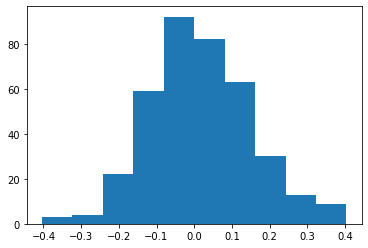

In [16]:
plt.hist(data_cor["corr"])

In [17]:
#Estos son los resultados si solo nos quedamos con los los años que si tenemos información del 2018 al 2020
datos_fin3=datos_fin3.sort_values(["municipio","anio","mes"])
años_ver=[2018,2019,2020]
mun_del=agru["Municipio"].unique()
tip_del=agru["Tipo de delito"].unique()
mun_li=[]
tip_li=[]
res=[]
for m in mun_del:
    for tipo in tip_del:
            incidentes=agru[(agru["Municipio"]==m) & (agru["Tipo de delito"]==tipo) &(agru["Año"].isin(años_ver))]["num_inc"]
            produc=datos_fin3[(datos_fin3["municipio"]==m) & (datos_fin3["anio"].isin(años_ver))]["prod_fin_men"]
            cor=np.corrcoef(incidentes,produc)[0,1]
            mun_li.append(m)
            tip_li.append(tipo)
            res.append(cor)

C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [18]:
#Datos reducidos
data_cor=pd.DataFrame({"municipio":mun_li,"tipo_de_delito":tip_li,"corr":res}).sort_values(["corr"],ascending=False)
data_cor.head(60)

,municipio,tipo_de_delito,corr
344,Tangamandapio,Amenazas,0.471609
4,Acuitzio,Narcomenudeo,0.448128
322,Susupuato,Homicidio,0.408387
211,Morelia,Lesiones,0.388433
6,Acuitzio,Robo,0.358289
192,Madero,Amenazas,0.355798
507,Ziracuaretiro,Lesiones,0.347719
91,Copándaro,Lesiones,0.336214
308,Sahuayo,Narcomenudeo,0.328133
208,Morelia,Amenazas,0.323267


C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  7., 39., 72., 75., 58., 51., 27., 15.,  4.]),
 array([-4.71530722e-01, -3.77216718e-01, -2.82902713e-01, -1.88588709e-01,
        -9.42747049e-02,  3.92993312e-05,  9.43533036e-02,  1.88667308e-01,
         2.82981312e-01,  3.77295316e-01,  4.71609320e-01]),
 <a list of 10 Patch objects>)

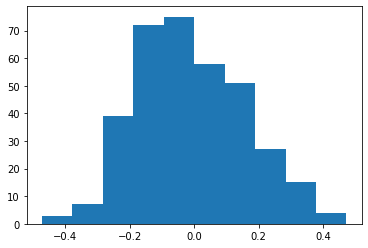

In [19]:
#Ver como se distribuyen las correlaciones
plt.hist(data_cor["corr"])

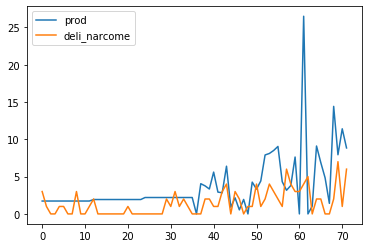

In [20]:
#datos de producción de aguacate
#En este caso obtenemos una correlación postiva , es decir que cuando aumenta el delito también lo hace la producción de aguacates

prodi=datos_fin3[datos_fin3["municipio"]=="Pátzcuaro"]["prod_fin_men"]#.unique()
delit=agru[(agru["Municipio"]=="Pátzcuaro") & (agru["Tipo de delito"]=="Narcomenudeo")]["num_inc"]

datos=pd.DataFrame({"prod":list(prodi),"deli_narcome":list(delit)})
datos["prod"]=datos["prod"]/100000
#(datos.loc[:,"prodi"]/100000).plot()
datos.plot()


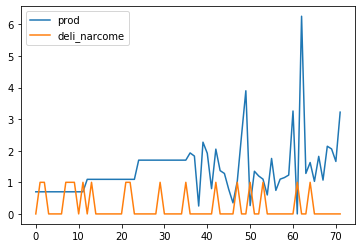

In [21]:
#Datos de delitos
#Aquí observamos como se comportan uno de los municipios con corr negativa, es decir que cuando no existe el
#delito hay alza en la producción de aguacates , mientras que cuando existe el delito baja la producción de aguacates
#Esto me hace pensar que quiza cuando no hay producción de aguacates los narcotraficantes se dedican a realizar 
#otros actos delictivos que les generen remuneración 
prodi=datos_fin3[datos_fin3["municipio"]=="Tlazazalca"]["prod_fin_men"]#.unique()
delit=agru[(agru["Municipio"]=="Tlazazalca") & (agru["Tipo de delito"]=="Narcomenudeo")]["num_inc"]

datos=pd.DataFrame({"prod":list(prodi),"deli_narcome":list(delit)})
datos["prod"]=datos["prod"]/100000
#(datos.loc[:,"prodi"]/100000).plot()
datos.plot()

In [22]:
#Aquí se calculan las correlaciones para todo el estado de Michoacán
tip_del=agru["Tipo de delito"].unique()
mun_li=[]
tip_li=[]
res=[]
deli_tota=agru.groupby(["Tipo de delito","Año","mes"],as_index=False).agg({"num_inc":"sum"})
dato_tota=datos_fin3.groupby(["anio","mes"],as_index=False).agg({"prod_fin_men":"sum"})
for i in tip_del:
    incidentes=deli_tota[deli_tota["Tipo de delito"]==i]["num_inc"]
    produc=dato_tota["prod_fin_men"]
    cor=np.corrcoef(incidentes,produc)[0,1]
    tip_li.append(i)
    res.append(cor)

pd.DataFrame({"tip_li":tip_li,"res":res})

C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Luis_Romero\anaconda3\lib\site-packages\numpy\lib\function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


,tip_li,res
0,Amenazas,0.365659
1,Extorsión,-0.127221
2,Homicidio,0.252033
3,Lesiones,0.298375
4,Narcomenudeo,0.299981
5,Rapto,NaN
6,Robo,0.099922
7,Secuestro,-0.001894


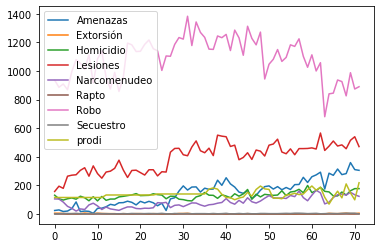

In [23]:
#Aquí podemos revisar las relaciones que existen entre cada uno de los delitos y todo el estado 
#de michoacan
prodi=dato_tota["prod_fin_men"]#.unique()
delit=[]
tip_del=list(tip_del)
for i in tip_del:
    delit.append(list(deli_tota[(deli_tota["Tipo de delito"]==i)]["num_inc"]))
#print(tip_del)
tip_del.append("prodi")
delit.append(prodi)
dict(zip(tip_del,delit))
datos=pd.DataFrame(dict(zip(tip_del,delit)))
datos


datos["prodi"]=datos["prodi"]/1000000
datos.plot()
